In [1357]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import gymnasium
import cv2
from PIL import Image, ImageDraw
import os
from sklearn.metrics import confusion_matrix
#from tqdm import tqdm

In [1358]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
IMG_SIZE = 128  

In [1359]:
class DataSet():
    def __init__(self):# 1. Параметры генератора
        self.CELL_COUNT_RANGE = (1, 10)  # Количество клеток на изображение (минимум, максимум)
        self.CELL_SIZE_RANGE = (5, 15)  # Диаметр клеток (минимум, максимум)
        self.CELL_COLOR_RANGE = ((100, 0, 0), (255, 100, 100))  # Цвет клеток (минимум, максимум по BGR)
        self.BACKGROUND_COLOR = (247, 131, 243)  # Розовый фон
        self.OVERLAP_PROBABILITY = 0.1  # Вероятность перекрытия клетки с другой
    
    def random_color(self, color_range):
        """Генерирует случайный цвет в заданном диапазоне."""
        return tuple(random.randint(color_range[0][i], color_range[1][i]) for i in range(3))

    def generate_blood_cell_image(self):
        """Генерирует одно изображение с клетками крови."""
        image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), self.BACKGROUND_COLOR)
        draw = ImageDraw.Draw(image)
        cell_count = random.randint(self.CELL_COUNT_RANGE[0], self.CELL_COUNT_RANGE[1])
        cells = []  # Список координат и размеров клеток, чтобы отслеживать перекрытия

        for _ in range(cell_count):
            cell_size = random.randint(self.CELL_SIZE_RANGE[0], self.CELL_SIZE_RANGE[1])

            # Попробуем найти позицию для клетки, чтобы избежать перекрытия (если OVERLAP_PROBABILITY низкая)
            max_attempts = 100
            for attempt in range(max_attempts):
                x = random.randint(cell_size, IMG_SIZE - cell_size)
                y = random.randint(cell_size, IMG_SIZE - cell_size)

                # Проверяем, перекрывается ли новая клетка с существующими
                overlap = False
                if random.random() > self.OVERLAP_PROBABILITY: # Проверяем, нужно ли вообще проверять перекрытие
                    for existing_x, existing_y, existing_size in cells:
                        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
                        if distance < (cell_size + existing_size) * 0.7:  # Уменьшил коэфф. для допущения небольшого перекрытия
                            overlap = True
                            break

                if not overlap:
                    break # Нашли подходящую позицию

            if overlap and attempt == max_attempts-1 :
                #Если не нашли хорошую позицию, то игнорируем данную клетку
                continue


            cell_color = self.random_color(self.CELL_COLOR_RANGE)
            draw.ellipse((x - cell_size, y - cell_size, x + cell_size, y + cell_size), fill=cell_color)
            cells.append((x, y, cell_size))

        return np.array(image), cell_count

    def generate_dataset(self,num_images, output_dir="blood_cell_dataset"):
        """Генерирует набор данных изображений и меток."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        images = []
        labels = []

        for i in range(num_images):
            image, cell_count = self.generate_blood_cell_image()
            images.append(image)
            labels.append(cell_count)

            # Сохранение изображений (опционально)
            image_path = os.path.join(output_dir, f"image_{i}.png")
            cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

        return images, labels

In [1360]:
def get_dataloader(subset):
    return DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)

In [1361]:
class Flatten(nn.Module):
    def forward(self, batch):
        return batch.reshape(batch.size(0), -1)
    
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(64 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2).float()  # Изменяем порядок осей
        x = F.relu(self.cv1(x))
        x = self.pool(x)  # применяем пулинг после первой свертки
        #print(f"После первого пулинга: {x.shape}")
        x = F.relu(self.cv2(x))
        x = self.pool(x)  # применяем пулинг после второй свертки
        #print(f"После второго пулинга: {x.shape}")
        #print(f"Размер тензора после свертки: {x.shape}")
        x = self.flatten(x)
        #print(f"Размер тензора после flatten: {x.shape}")
        x = x.view(x.size(0), -1)  # или reshape
        #print(f"Размер тензора перед линейным слоем: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [1362]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        #self.images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]  # Преобразуем в градации серого
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        #image = np.expand_dims(image, axis=0)  # Добавляем канал (1, H, W)

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.int32), torch.tensor(label, dtype=torch.long)

In [1363]:
class DataPreloading():
    def __init__(self, num_samples=1000):
        self.dataset_generator = DataSet()
        images, labels = self.dataset_generator.generate_dataset(num_samples)

        self.dataset = BloodCellDataset(images, labels)
    def get_train_data(self):
        return self.dataset

torch.Size([10, 128, 128, 3])


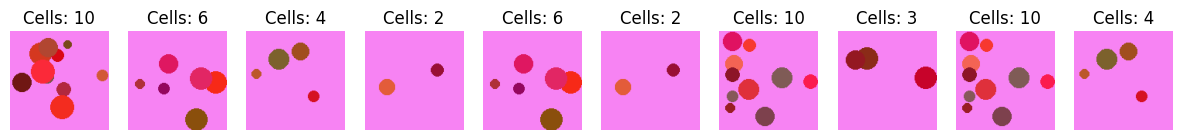

In [1364]:
NUM_IMAGES = 10
data_set = DataPreloading(num_samples=10)
data = data_set.get_train_data()
dataloader = DataLoader(data, batch_size=10, shuffle=True)
images, labels = next(iter(dataloader))
print(images.shape)
import matplotlib.pyplot as plt

def visualize_data(images, labels, num_samples=10):
    """Визуализирует несколько случайных изображений из набора данных."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        index = random.randint(0, len(images) - 1)
        axes[i].imshow(images[index])
        axes[i].set_title(f"Cells: {labels[index]}")
        axes[i].axis('off')
    plt.show()

visualize_data(images, labels)

In [ ]:
class DataSelectionEnv(gymnasium.Env):
    def __init__(self):
        super(DataSelectionEnv, self).__init__()
        self.train_data = DataPreloading().get_train_data()
        self.model = SimpleCNN()
        self.criterion = nn.CrossEntropyLoss()
        self.indexes = self.class_select()
        self.optim = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        
        # Пространство действий: вероятности выбора изображений для каждого класса
        self.action_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
        self.observation_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
    
    def class_select(self):#возвращаем словарь из индексов принадлежащим классам
        ls = {i: [] for i in range(1,NUM_CLASSES+1)} #создали пустой словарь на 10 классов

        for x, (_, label) in enumerate(self.train_data):
            label_value = label.item()
            ls[label_value].append(x) #индекс каждого изображения из train_data положили в нужный класс в зависимости от метки

        return ls
    
    def sample(self, action):#action - тензор распределения процентов изображений от каждого класса в выборке
        action = F.softmax(torch.tensor(action), dim=-1).numpy()
        index = []

        for i in range(NUM_CLASSES):
            num_img = int(action[i] * BATCH_SIZE) #определили количество изображений для i-го класса в выборке из batch_size изображений
            indexes = np.random.choice(self.indexes[i+1], num_img, replace=True) #рандомно выбираем вычисленное количество изображений из изображений нужного класса, возвращаем их индексы
            index.extend(indexes)#добавляем найденные индексы в выборку

        return Subset(self.train_data, index)#состовляем subset 
    
    def step(self, action):
        # в этой функции мы создаем выборку на основе action и проверяем, насколько улучшилось или ухудшилось предсказание сети
        action = np.clip(action + np.random.uniform(-0.05, 0.05, size=action.shape), 0, 1)
        train_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        test_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action

        train_dataloader = get_dataloader(train_subset) #создали dataloader, выдающий этот batch из 32 элементов 
        test_dataloader = get_dataloader(test_subset) #создаем dataloader для тестирования

        prev_acc, _ = self.evaluate(test_dataloader) #вычиляем текущую точность модели на тестовой выборке
        self.train_model(train_dataloader) #тренируем модель на тренировчной выборке
        new_acc, err_per_cl = self.evaluate(test_dataloader) #проверяем модель после тренировки на тестовой выборке

        reward = new_acc #вычисляем награду
        for i in range(NUM_CLASSES):
            if err_per_cl[i]==1:
                reward-=30
            if err_per_cl[i]<1 and err_per_cl[i]>=0.9:
                reward+=5
            elif err_per_cl[i]<0.9 and err_per_cl[i]>=0.8:
                reward+=10
            elif err_per_cl[i]<0.8 and err_per_cl[i]>=0.7:
                reward+=15
            elif err_per_cl[i]<0.7 and err_per_cl[i]>=0.6:
                reward+=20
            elif err_per_cl[i]<0.6 and err_per_cl[i]>=0.5:
                reward+=25
            elif err_per_cl[i]<0.5:
                reward+=50
            
        #reward = new_acc
        return reward, err_per_cl
    
    def train_model(self, dataloader):
        # на вход приходит dataloader выдающий batch изображений и ответов к ним
        batch = next(iter(dataloader)) #получили батч из тренирогочного dataloader 
        images, labels = batch #разделили полученный батч на изображения и метки

        self.optim.zero_grad() #обновили optimizer
        output = self.model(images) #получили тензор(batch_size, NUM_CLASSES) с распределением вероятностей для каждого изображения
        #print(output)
        loss = self.criterion(output, labels-1) #вычислили ошибку с помощью CrossEntropyLoss
        loss.backward()
        self.optim.step()
    
    def evaluate(self,dataloader):#тестирование модели
        self.model.eval()#перевели модель в оценочный режим
        correct = 0
        total = 0
        ls = [0]*10
        ers = [0]*10
        with torch.no_grad():
            batch = next(iter(dataloader)) #получили из dataloader batch на batch_size изображений
            images,labels = batch # получили изображения и ответы
            output = self.model(images) #получили тензор(batch_size,NUM_CLASSES) с распределениями вероятснотей для каждого изображения
            predicted = torch.argmax(output,dim=1) #получили тезор(batch_size) с предложенными значениями классов
            correct += (predicted==labels).sum().item() #нашли количество правильных ответов
            total = BATCH_SIZE #так как мы рассматриваем только один батч, следовательно общий размер - BATCH_SIZE

            for i in range(len(labels)):
                if predicted[i]==labels[i]:
                    ls[labels[i]-1]+=1  
                else:
                    ers[labels[i]-1]+=1
                    ls[labels[i]-1]+=1
            error_per_class = [ers[i]/ls[i] for i in range(NUM_CLASSES)]

        accuracy = (correct / total) if total > 0 else 0 # находим точность на данной выборке
        print(accuracy)
        return accuracy, error_per_class


In [1366]:
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

In [1367]:
class Critic(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [1368]:
def actor_critic(env, actor, critic, episodes=100, max_steps=100, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)
    EPS = 0.3 #значение epsilon для клиппинга обычно от 0.1 до 0.3
    state = np.ones(NUM_CLASSES) / 2 # проценты точности на каждом классе
    for episode in range(episodes):
        step = 0
        while step < max_steps:
            print(step, state)
            step += 1
            state_tensor = torch.FloatTensor(state)#флотовый тензор с процентами точности
            epsilon = 0.1  # Вероятность случайного выбора действия
            if np.random.rand() < epsilon:
                action = np.random.dirichlet(np.ones_like(state))  # Случайное распределение
                action_probabilities = torch.FloatTensor(action)  # Создаем фейковый тензор, чтобы избежать ошибки
            else:
                with torch.no_grad():  
                    action_probabilities = actor(state_tensor)  
                    action = action_probabilities.detach().numpy()

            old_log_prob = torch.log(action_probabilities)
            #print(action)
            reward, next_state = env.step(action) #рассчитываем награду и next_state, где next_state - ndarray процента ошибок по классам на тестовой выборке из batch_size элементов
            next_state_tensor = torch.FloatTensor(next_state)#создаем тензор от next_state
            new_action_probabilities = actor(next_state_tensor)
            new_log_prob = torch.log(new_action_probabilities)

            value = critic(state_tensor) #критик предсказывает значение на основе предыдущего тензора 
            next_value = critic(next_state_tensor) #и предсказывает значение на основе нового тензора
            
            advantage = reward + (gamma * next_value) - value
            print(advantage)
            loss_critic = advantage.pow(2).mean()

            #вычисляем потерю актера с учетом клиппинга
            ratio = torch.exp(new_log_prob - old_log_prob)
            surrogate_loss = torch.min(ratio * advantage, torch.clamp(ratio, 1 - EPS, 1 + EPS) * advantage)
            entropy_bonus = -torch.sum(action_probabilities * torch.log(action_probabilities + 1e-6))  # Энтропия
            
            loss_actor = -surrogate_loss.mean()
            loss_actor += 0.01 * entropy_bonus  # Добавляем в функцию потерь
            
            state = next_state

            #вводим фиктивную раномерно распределенную выборку для более объективной оценки точности
            if step == 99:
                test_state = np.ones(NUM_CLASSES)/NUM_CLASSES
                test_action_probabilities = torch.FloatTensor(test_state)
                test_action = test_action_probabilities.numpy()
                _,state = env.step(test_action)
            #обновляем политику раз в 10 шагов
            if step % 10 != 0:
                optimizer_actor.zero_grad()
                loss_actor.backward()
                optimizer_actor.step()
            else:
                optimizer_critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                optimizer_critic.step()
    return


In [1369]:
env = DataSelectionEnv()
#print(env.)
actor = Actor(10,10)
critic = Critic(10)
actor_critic(env,actor,critic,episodes=1,max_steps=1000)

0 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
0.09375
0.1015625
tensor([500.2638], grad_fn=<SubBackward0>)
1 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
0.09375
0.09375
tensor([500.1412], grad_fn=<SubBackward0>)
2 [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.09375
0.09375
tensor([500.1124], grad_fn=<SubBackward0>)
3 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
0.109375
0.09375
tensor([499.9292], grad_fn=<SubBackward0>)
4 [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.09375
0.09375
tensor([500.1283], grad_fn=<SubBackward0>)
5 [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.09375
0.09375
tensor([500.1652], grad_fn=<SubBackward0>)
6 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
0.1015625
0.09375
tensor([500.0777], grad_fn=<SubBackward0>)
7 [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.09375
0.09375
tensor([500.1396], grad_fn=<SubBackward0>)
8 [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.09375
0.09375
tensor([500.0906], grad_fn=<SubBackward

KeyboardInterrupt: 